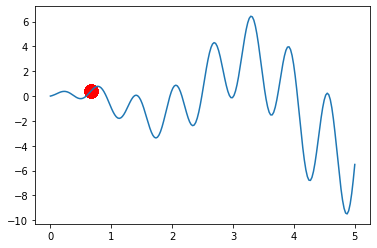

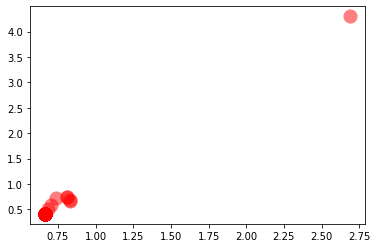

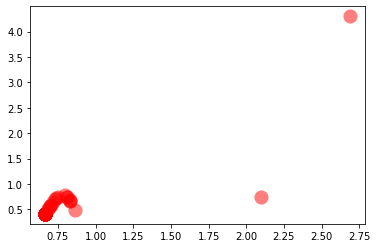

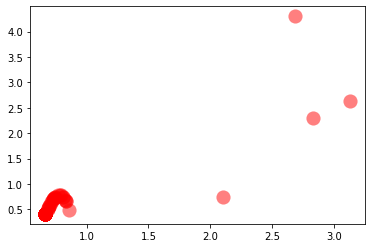

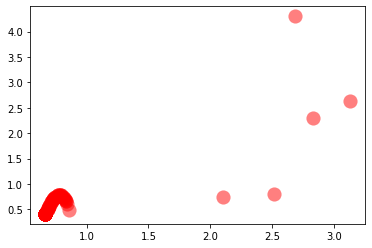

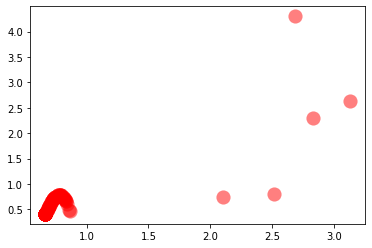

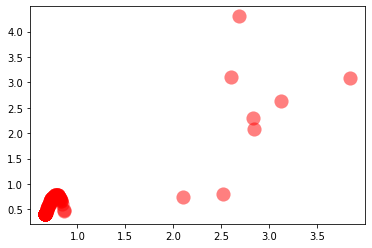

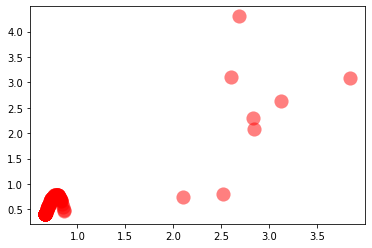

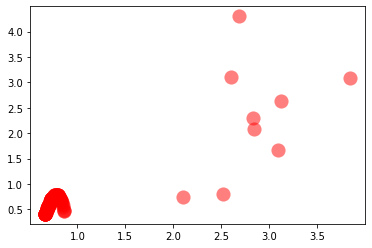

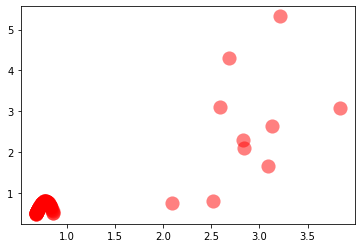

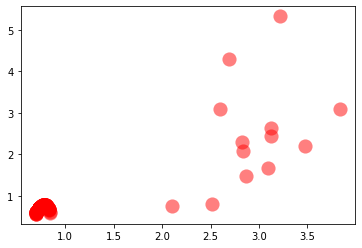

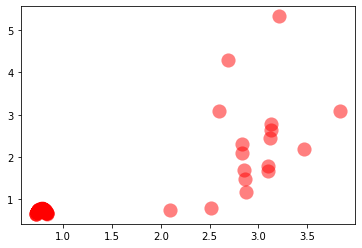

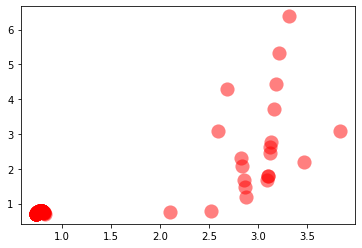

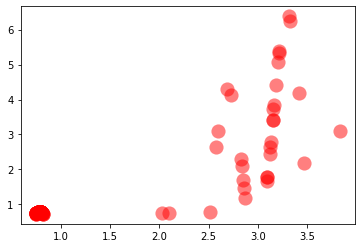

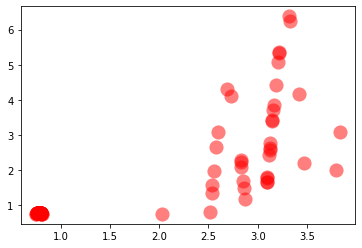

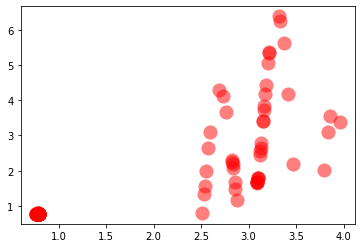

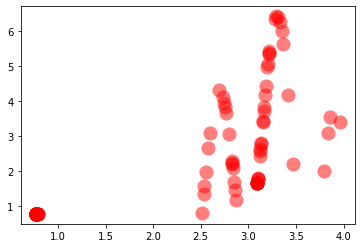

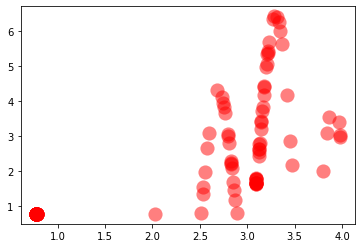

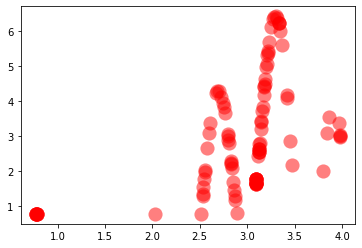

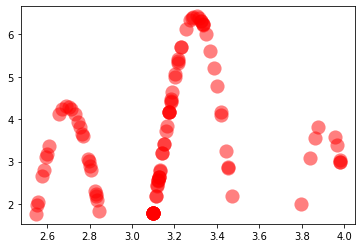

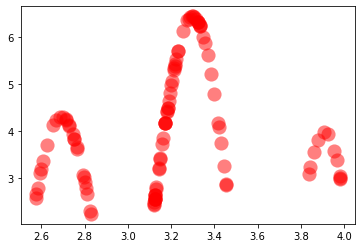

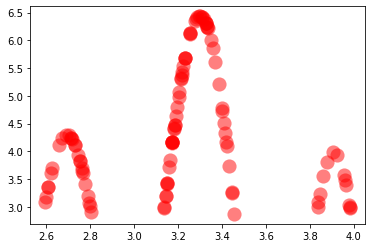

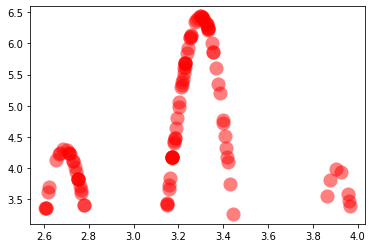

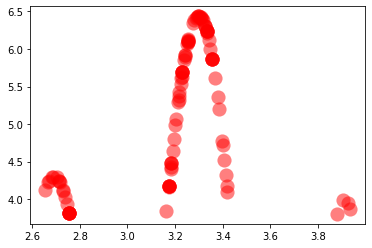

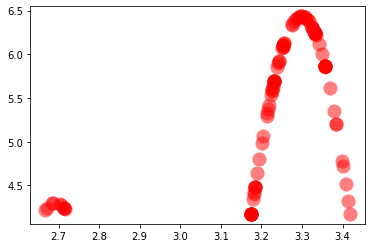

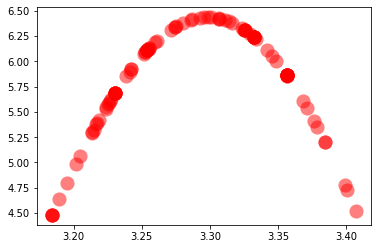

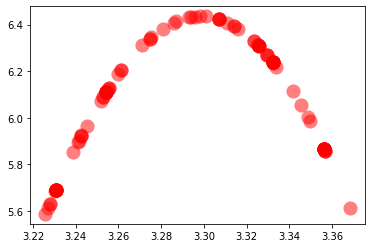

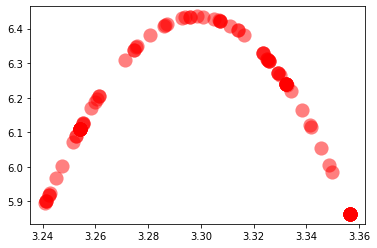

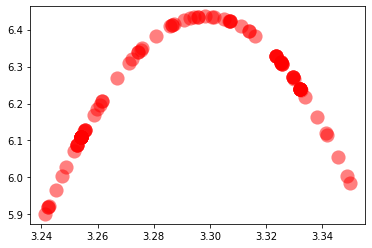

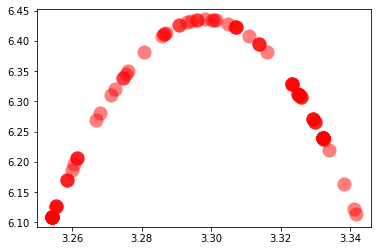

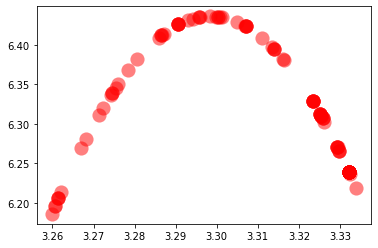

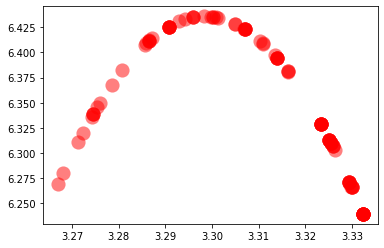

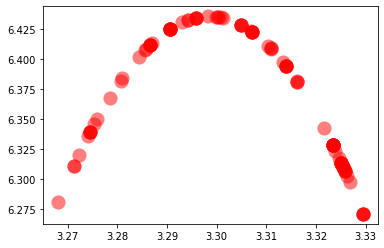

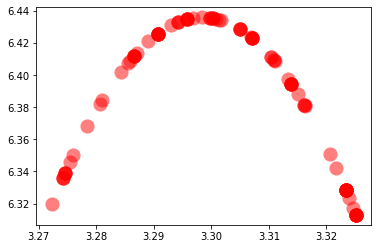

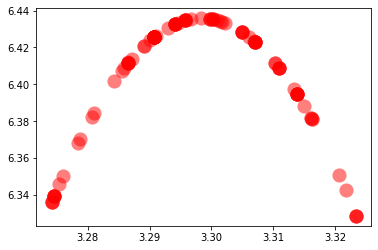

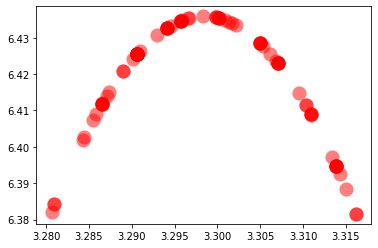

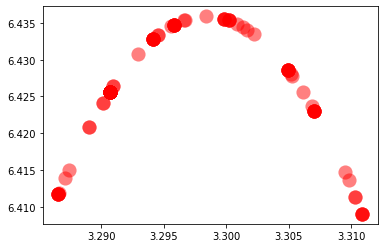

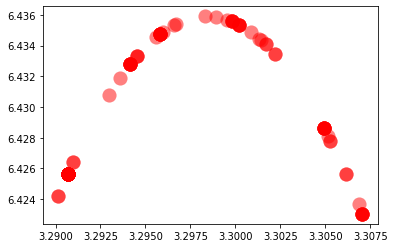

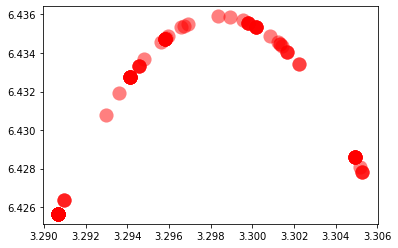

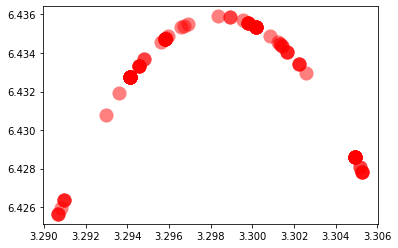

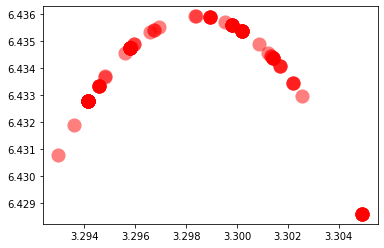

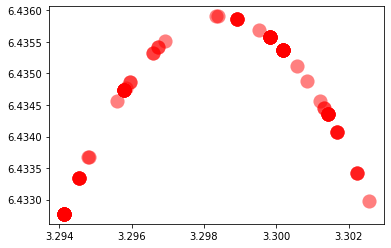

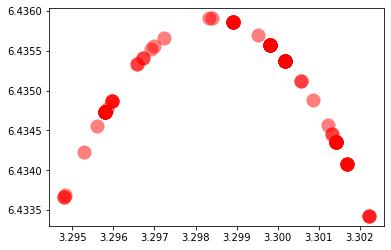

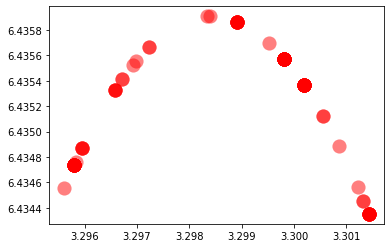

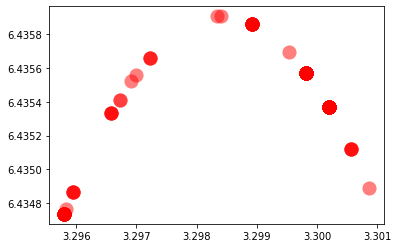

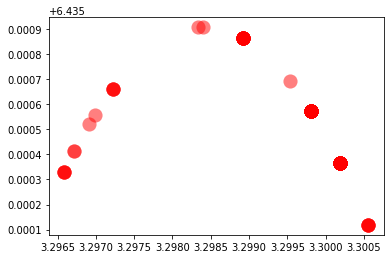

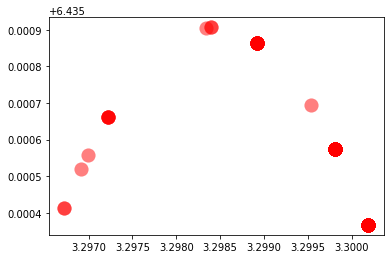

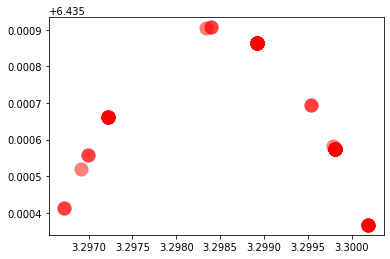

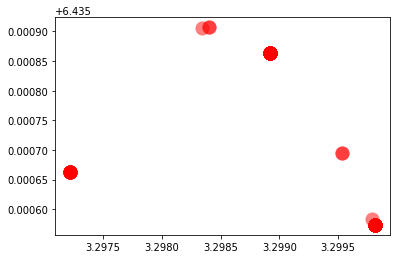

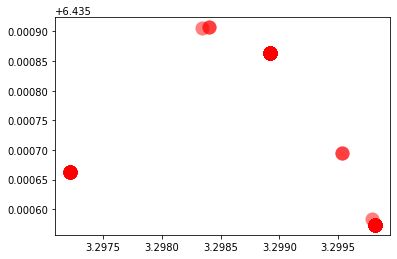

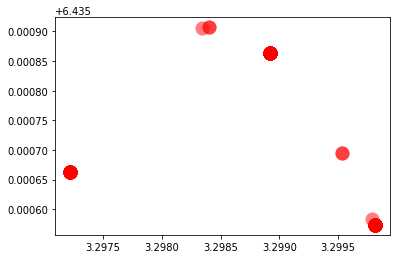

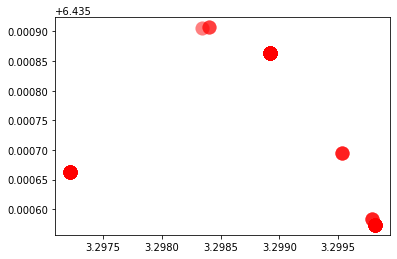

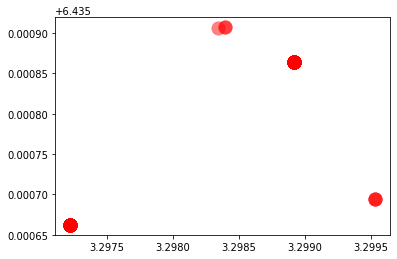

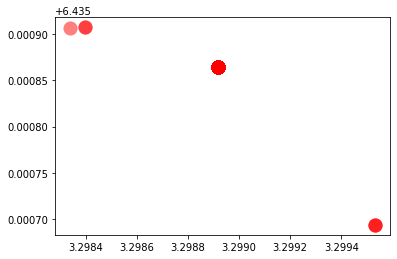

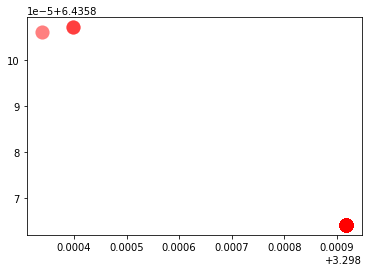

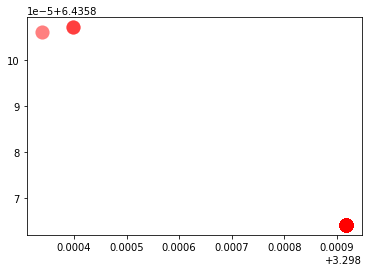

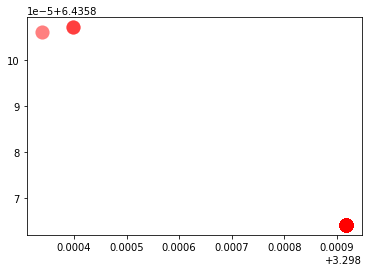

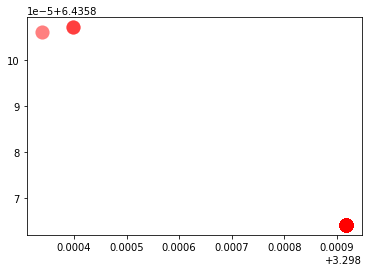

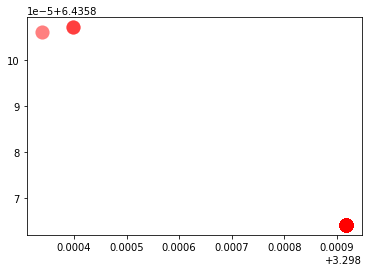

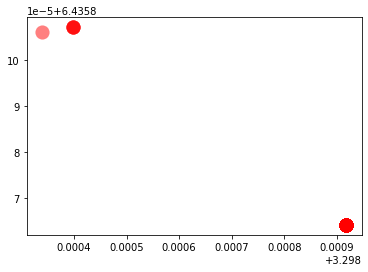

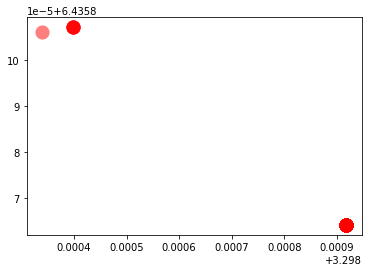

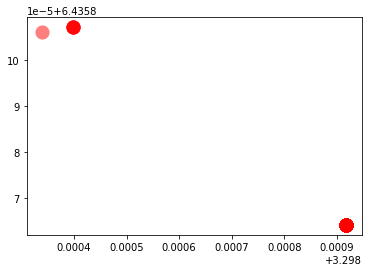

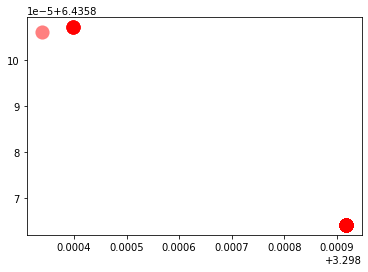

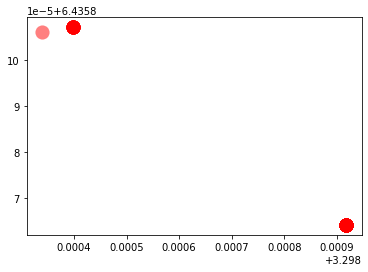

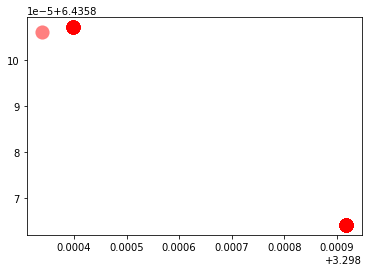

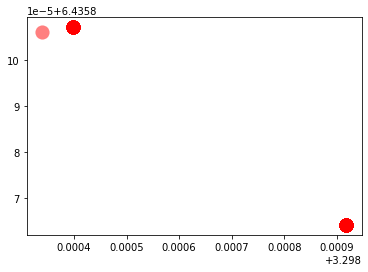

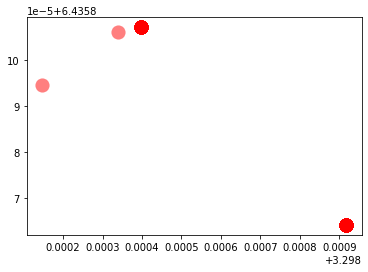

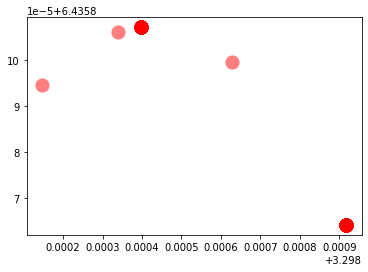

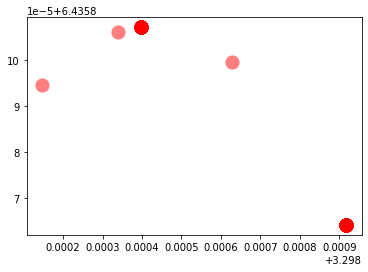

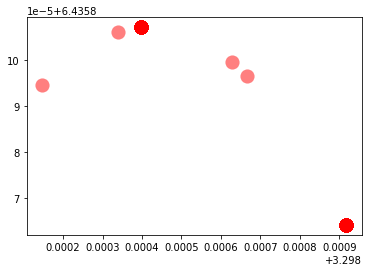

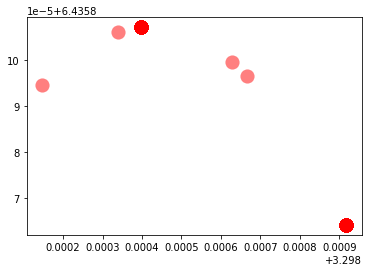

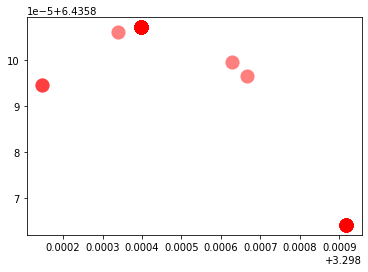

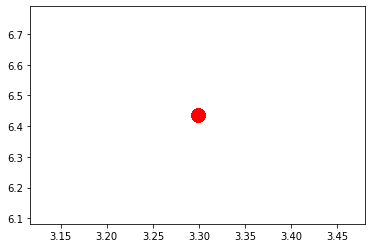

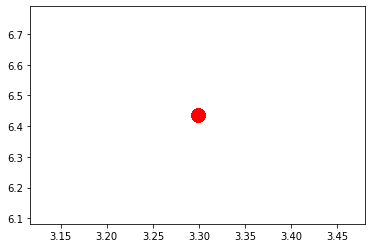

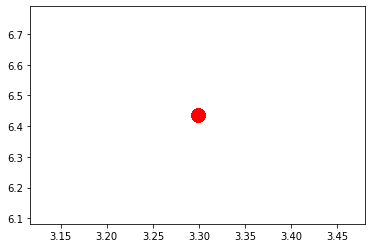

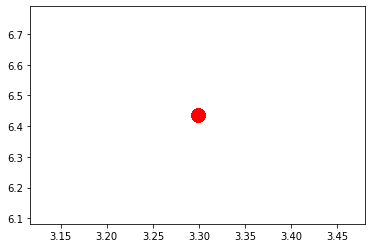

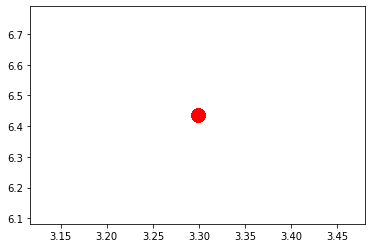

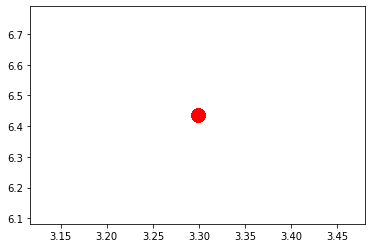

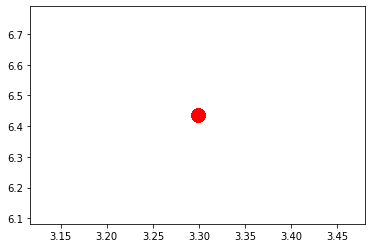

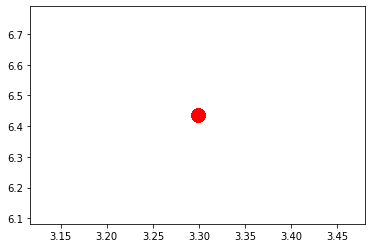

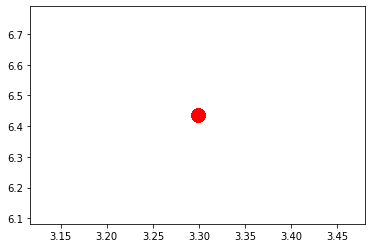

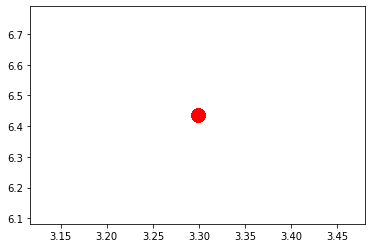

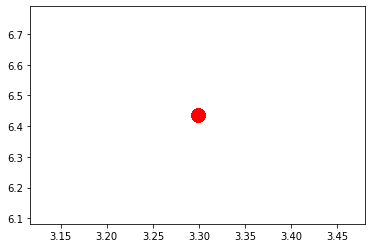

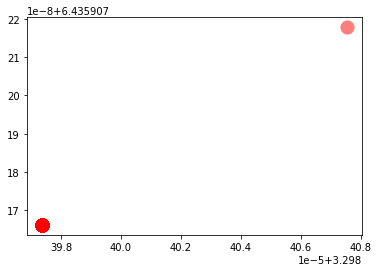

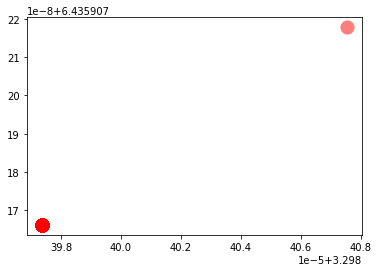

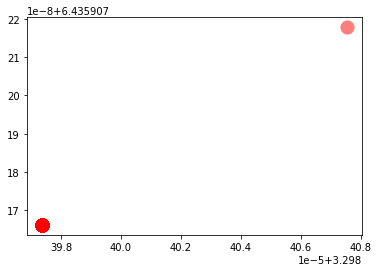

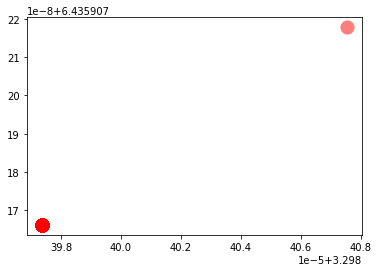

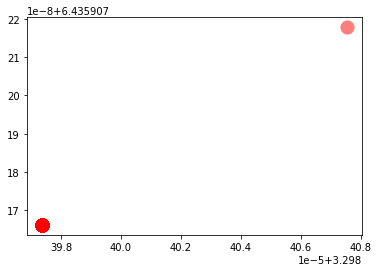

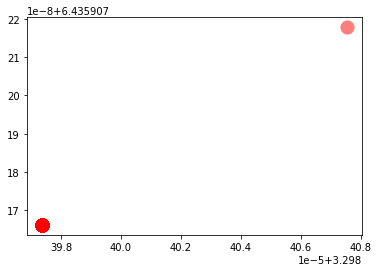

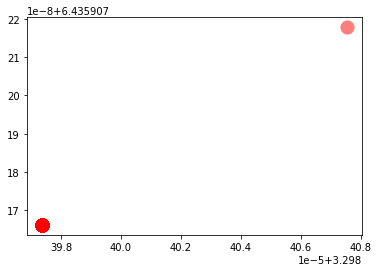

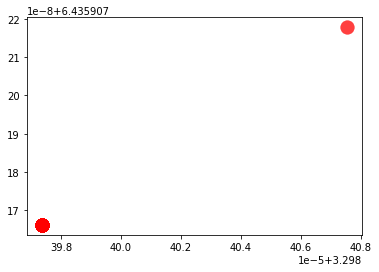

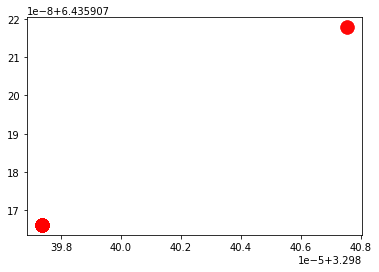

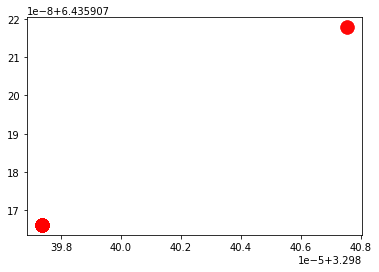

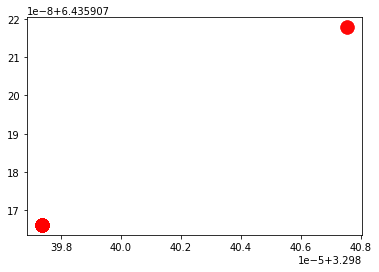

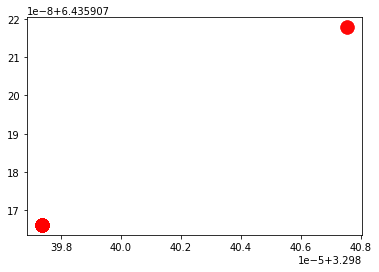

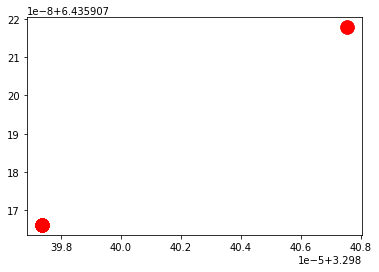

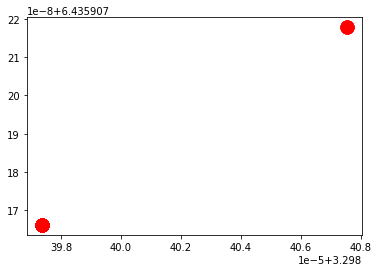

KeyboardInterrupt: 

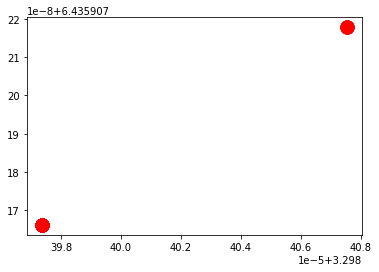

In [1]:
import numpy as np
import matplotlib.pyplot as plt

DNA_SIZE = 1             # DNA (real number)
DNA_BOUND = [0, 5]       # solution upper and lower bounds
N_GENERATIONS = 200
POP_SIZE = 100           # population size
N_KID = 50               # n kids per generation

 
def F(x): return np.sin(10*x)*x + np.cos(2*x)*x     # to find the maximum of this function


# find non-zero fitness for selection
def get_fitness(pred): return pred.flatten()


def make_kid(pop, n_kid):
    # generate empty kid holder
    kids = {'DNA': np.empty((n_kid, DNA_SIZE))}
    kids['mut_strength'] = np.empty_like(kids['DNA'])
    for kv, ks in zip(kids['DNA'], kids['mut_strength']):
        # crossover (roughly half p1 and half p2)
        p1, p2 = np.random.choice(np.arange(POP_SIZE), size=2, replace=False)
        cp = np.random.randint(0, 2, DNA_SIZE, dtype=np.bool)  # crossover points
        kv[cp] = pop['DNA'][p1, cp]
        kv[~cp] = pop['DNA'][p2, ~cp]
        ks[cp] = pop['mut_strength'][p1, cp]
        ks[~cp] = pop['mut_strength'][p2, ~cp]

        # mutate (change DNA based on normal distribution)
        ks[:] = np.maximum(ks + (np.random.rand(*ks.shape)-0.5), 0.)    # must > 0
        kv += ks * np.random.randn(*kv.shape)
        kv[:] = np.clip(kv, *DNA_BOUND)    # clip the mutated value
    return kids


def kill_bad(pop, kids):
    # put pop and kids together
    for key in ['DNA', 'mut_strength']:
        pop[key] = np.vstack((pop[key], kids[key]))

    fitness = get_fitness(F(pop['DNA']))            # calculate global fitness
    idx = np.arange(pop['DNA'].shape[0])
    good_idx = idx[fitness.argsort()][-POP_SIZE:]   # selected by fitness ranking (not value)
    for key in ['DNA', 'mut_strength']:
        pop[key] = pop[key][good_idx]
    return pop


pop = dict(DNA=5 * np.random.rand(1, DNA_SIZE).repeat(POP_SIZE, axis=0),   # initialize the pop DNA values
           mut_strength=np.random.rand(POP_SIZE, DNA_SIZE))                # initialize the pop mutation strength values

plt.ion()       # something about plotting
x = np.linspace(*DNA_BOUND, 200)
plt.plot(x, F(x))

for _ in range(N_GENERATIONS):
    # something about plotting
    if 'sca' in globals(): sca.remove()
    sca = plt.scatter(pop['DNA'], F(pop['DNA']), s=200, lw=0, c='red', alpha=0.5); plt.pause(0.05)

    # ES part
    kids = make_kid(pop, N_KID)
    pop = kill_bad(pop, kids)   # keep some good parent for elitism

plt.ioff(); plt.show()

# 1+1ES算法


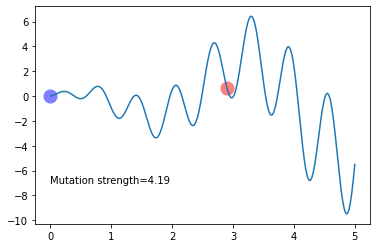

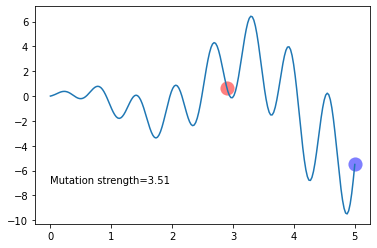

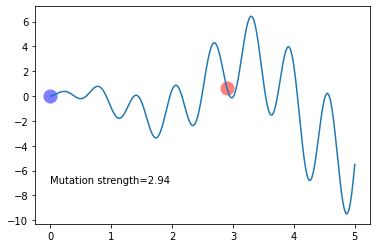

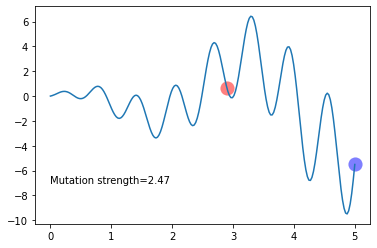

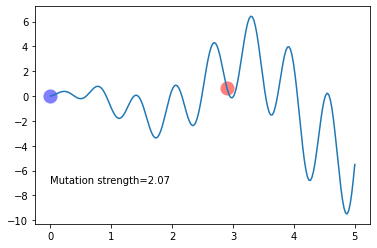

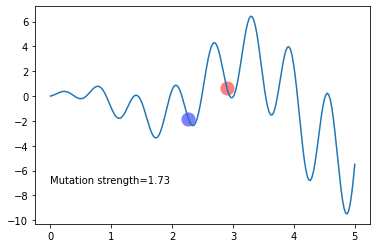

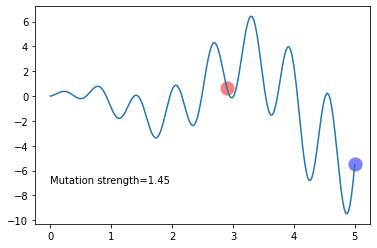

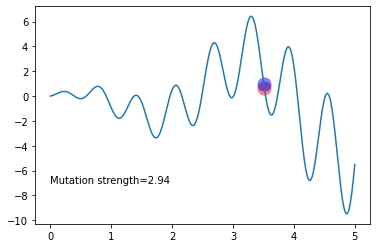

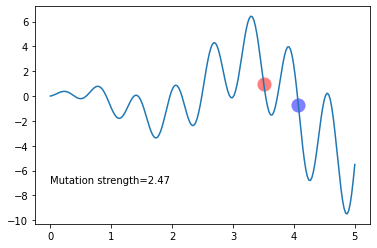

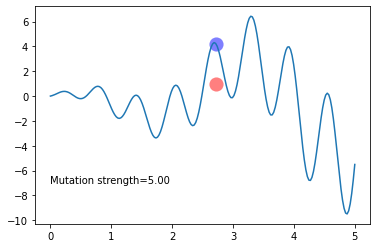

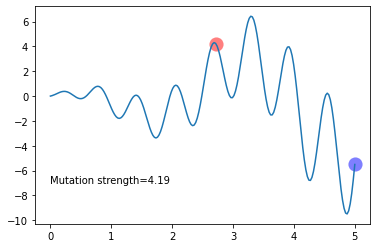

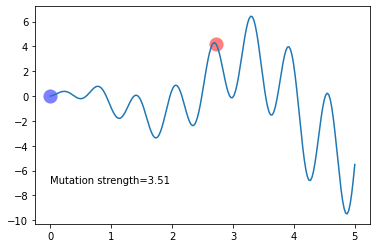

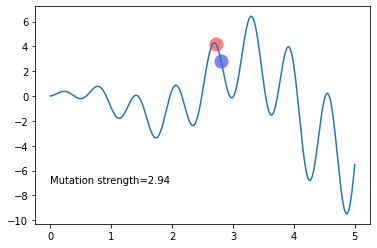

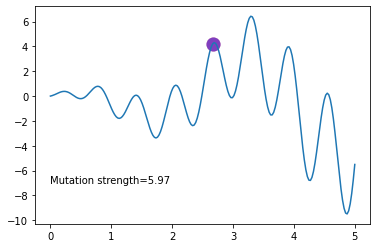

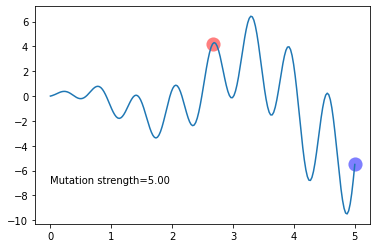

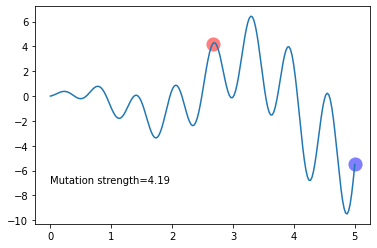

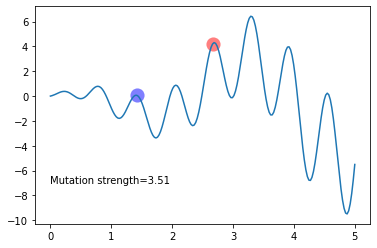

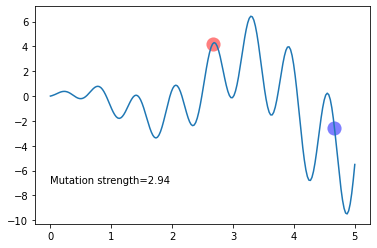

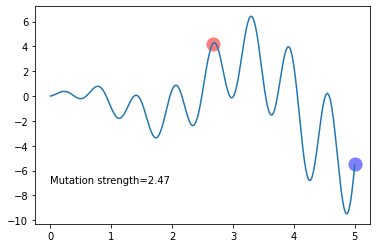

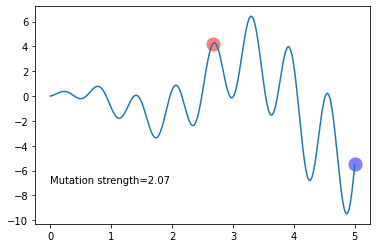

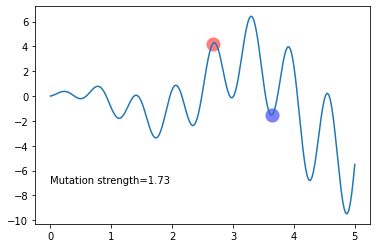

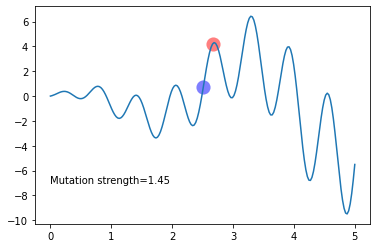

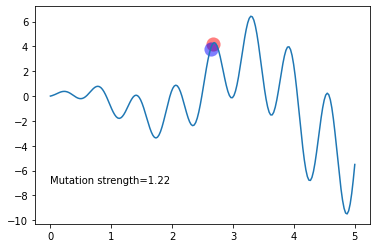

KeyboardInterrupt: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

DNA_SIZE = 1             # DNA (real number)
DNA_BOUND = [0, 5]       # solution upper and lower bounds
N_GENERATIONS = 200
MUT_STRENGTH = 5.        # initial step size (dynamic mutation strength)


def F(x): return np.sin(10*x)*x + np.cos(2*x)*x     # to find the maximum of this function


# find non-zero fitness for selection
def get_fitness(pred): return pred.flatten()


def make_kid(parent):
    # no crossover, only mutation
    k = parent + MUT_STRENGTH * np.random.randn(DNA_SIZE)
    k = np.clip(k, *DNA_BOUND)
    return k


def kill_bad(parent, kid):
    global MUT_STRENGTH
    fp = get_fitness(F(parent))[0]
    fk = get_fitness(F(kid))[0]
    p_target = 1/5
    if fp < fk:     # kid better than parent
        parent = kid
        ps = 1.     # kid win -> ps = 1 (successful offspring)
    else:
        ps = 0.
    # adjust global mutation strength
    MUT_STRENGTH *= np.exp(1/np.sqrt(DNA_SIZE+1) * (ps - p_target)/(1 - p_target))
    return parent


parent = 5 * np.random.rand(DNA_SIZE)   # parent DNA

plt.ion()       # something about plotting
x = np.linspace(*DNA_BOUND, 200)

for _ in range(N_GENERATIONS):
    # ES part
    kid = make_kid(parent)
    py, ky = F(parent), F(kid)       # for later plot
    parent = kill_bad(parent, kid)

    # something about plotting
    plt.cla()
    plt.scatter(parent, py, s=200, lw=0, c='red', alpha=0.5,)
    plt.scatter(kid, ky, s=200, lw=0, c='blue', alpha=0.5)
    plt.text(0, -7, 'Mutation strength=%.2f' % MUT_STRENGTH)
    plt.plot(x, F(x)); plt.pause(0.05)

plt.ioff(); plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.distributions import MultivariateNormalFullCovariance

DNA_SIZE = 2         # parameter (solution) number
N_POP = 20           # population size
N_GENERATION = 100   # training step
LR = 0.02            # learning rate


# fitness function
def get_fitness(pred): return -((pred[:, 0])**2 + pred[:, 1]**2)

# build multivariate distribution
mean = tf.Variable(tf.random_normal([2, ], 13., 1.), dtype=tf.float32)
cov = tf.Variable(5. * tf.eye(DNA_SIZE), dtype=tf.float32)
mvn = MultivariateNormalFullCovariance(loc=mean, covariance_matrix=cov)
make_kid = mvn.sample(N_POP)                                    # sampling operation

# compute gradient and update mean and covariance matrix from sample and fitness
tfkids_fit = tf.placeholder(tf.float32, [N_POP, ])
tfkids = tf.placeholder(tf.float32, [N_POP, DNA_SIZE])
loss = -tf.reduce_mean(mvn.log_prob(tfkids)*tfkids_fit)         # log prob * fitness
train_op = tf.train.GradientDescentOptimizer(LR).minimize(loss) # compute and apply gradients for mean and cov

sess = tf.Session()
sess.run(tf.global_variables_initializer())                     # initialize tf variables

# something about plotting (can be ignored)
n = 300
x = np.linspace(-20, 20, n)
X, Y = np.meshgrid(x, x)
Z = np.zeros_like(X)
for i in range(n):
    for j in range(n):
        Z[i, j] = get_fitness(np.array([[x[i], x[j]]]))
plt.contourf(X, Y, -Z, 100, cmap=plt.cm.rainbow); plt.ylim(-20, 20); plt.xlim(-20, 20); plt.ion()

# training
for g in range(N_GENERATION):
    kids = sess.run(make_kid)
    kids_fit = get_fitness(kids)
    sess.run(train_op, {tfkids_fit: kids_fit, tfkids: kids})    # update distribution parameters

    # plotting update
    if 'sca' in globals(): sca.remove()
    sca = plt.scatter(kids[:, 0], kids[:, 1], s=30, c='k');plt.pause(0.01)

print('Finished'); plt.ioff(); plt.show()

ModuleNotFoundError: No module named 'tensorflow.contrib'